# Diverging Color Maps

This notebook describes the creation of some diverging color maps for scientific visualization. The techniques are based on "[Diverging Color Maps for Scientific Visualization](http://www.kennethmoreland.com/color-maps/)" by Kenneth Moreland. It describes a diverging (double-ended) color map with a smooth transition in the middle to prevent artifacts at the midpoint.

In [1]:
from __future__ import print_function

## Msh Color Space

The diverging color maps are based off of a color space named Msh, which is simply polar coordinates for the CIELAB space. Here is the creating of an actual `MshColor` class for the `colormath` python package as well as the conversion function for it.

In [2]:
from colormath.color_objects import *
from colormath.color_conversions import convert_color, color_conversion_function
from colormath import color_diff

In [3]:
class MshColor(IlluminantMixin, ColorBase):
    '''
    Represents an Msh color as defined by [Moreland2009]. The Msh color space
    is basically just a polar representation of CIE Lab space.
    See `Diverging Color Maps for Scientific Visualization
    <http://www.kennethmoreland.com/color-maps/>` for more information.
    '''

    VALUES = ['msh_m', 'msh_s', 'msh_h']

    def __init__(self, msh_m, msh_s, msh_h, observer='2', illuminant='d50'):
        """
        :param float msh_m: M coordinate.
        :param float msh_s: s coordinate.
        :param float msh_h: h coordinate.
        :keyword str observer: Observer angle. Either ```2``` or ```10``` degrees.
        :keyword str illuminant: See :doc:`illuminants` for valid values.
        """

        super(MshColor, self).__init__()
        #: M coordinate
        self.msh_m = float(msh_m)
        #: C coordinate
        self.msh_s = float(msh_s)
        #: H coordinate
        self.msh_h = float(msh_h)

        #: The color's observer angle. Set with :py:meth:`set_observer`.
        self.observer = None
        #: The color's illuminant. Set with :py:meth:`set_illuminant`.
        self.illuminant = None

        self.set_observer(observer)
        self.set_illuminant(illuminant)

@color_conversion_function(LabColor, MshColor)
def Lab_to_Msh(cobj, *args, **kwargs):
    """
    Convert from CIE Lab to Msh.
    """

    msh_m = math.sqrt(math.pow(float(cobj.lab_l),2) +
                      math.pow(float(cobj.lab_a),2) +
                      math.pow(float(cobj.lab_b),2))
    msh_s = math.acos(float(cobj.lab_l)/msh_m)
    msh_h = math.atan2(float(cobj.lab_b), float(cobj.lab_a))
    
    return MshColor(msh_m, msh_s, msh_h,
                    observer=cobj.observer,
                    illuminant=cobj.illuminant)

@color_conversion_function(MshColor, LabColor)
def Msh_to_Lab(cobj, *args, **kwargs):
    """
    Convert from Msh to Lab.
    """
    
    lab_l = cobj.msh_m * math.cos(float(cobj.msh_s))
    lab_a = cobj.msh_m * math.sin(float(cobj.msh_s)) * math.cos(float(cobj.msh_h))
    lab_b = cobj.msh_m * math.sin(float(cobj.msh_s)) * math.sin(float(cobj.msh_h))
    return LabColor(lab_l, lab_a, lab_b,
                    illuminant=cobj.illuminant,
                    observer=cobj.observer)

## Diverging Color Map Generation

Here we create a class named `SmoothDivergingColorMap` designed to create diverging color maps based on the definition of the endpoints.

In [4]:
import numpy

In [5]:
class SmoothDivergingColorMap:
    def __init__(self,
                 low_color=sRGBColor(0.230, 0.299, 0.754),
                 high_color=sRGBColor(0.706, 0.016, 0.150),
                 mid_color=MshColor(88.0, 0.0, 0.0)):
        """
        :param color low_color: The color at the low end of the map.
        :param color high_color: The color at the high end of the map.
        :param color mid_color: The color at the middle of the map. Should be unsaturated.
        """
        self.low_msh = convert_color(low_color, MshColor)
        self.high_msh = convert_color(high_color, MshColor)
        
        # If the points are saturated and distinct, then we place a white point
        # in the middle. Otherwise we ignore it.
        if self.low_msh.msh_s > 0.05:
            if self.high_msh.msh_s > 0.05:
                if (abs(self.low_msh.msh_h - self.high_msh.msh_h) > math.pi/3.0) \
                     and mid_color:
                    # Both endpoints are saturated and unique and a midpoint was
                    # given. Interpolate through this midpoint and compute an
                    # appropriate hue spin.
                    mid_msh = convert_color(mid_color, MshColor)
                    self.midpoint_magnitude = mid_msh.msh_m
                    self.midpoint_low_hue = self.compute_hue_spin(self.low_msh,mid_msh)
                    self.midpoint_high_hue = self.compute_hue_spin(self.high_msh,mid_msh)
                else:
                    # Both endpoints are distinct colors, but they are either very close
                    # in hue or no middle point was given. In this case, interpolate
                    # directly between them.
                    self.midpoint_magnitude = None
            else:
                # The low color is saturated but the high color is unsaturated.
                # Interpolate directly between them, but adjust the hue of the unsaturated
                # high color.
                self.midpoint_magnitude = None
                self.high_msh.msh_h = self.compute_hue_spin(self.low_msh, self.high_msh)
        else:
            # The low color is unsaturated. Assume the high color is saturated. (If not,
            # then this is a boring map no matter what we do.) Interpolate directly
            # between them, but adjust the hue of the unsaturated low color.
            self.midpoint_magnitude = None
            self.low_msh.msh_h = self.compute_hue_spin(self.high_msh, self.low_msh)
            
    def compute_hue_spin(self, MshSaturated, MshUnsaturated):
        '''
        Given a saturated color and unsaturated color, both as MshColor objects,
        computes a spin component to use during interpolation in Msh space. The spin
        is considered the target hue to interpolate to.
        '''
        if MshSaturated.msh_m >= MshUnsaturated.msh_m:
            return MshSaturated.msh_h
        else:
            hSpin = (MshSaturated.msh_s * 
                     math.sqrt(math.pow(MshUnsaturated.msh_m,2) - 
                               math.pow(MshSaturated.msh_m,2)) /
                     (MshSaturated.msh_m * math.sin(MshSaturated.msh_s)))
            if MshSaturated.msh_h > -math.pi/3:
                return MshSaturated.msh_h + hSpin
            else:
                return MshSaturated.msh_h - hSpin
                
    def print_self(self):
        print('Low Color:')
        print('\t', self.low_msh)
        print('\t', convert_color(self.low_msh, LabColor))
        print('\t', convert_color(self.low_msh, sRGBColor))
        
        print('Middle Color:')
        if (self.midpoint_magnitude):
            print('\t Magnitude', self.midpoint_magnitude)
            print('\t Low Hue', self.midpoint_low_hue)
            print('\t High Hue', self.midpoint_high_hue)
        else:
            print('\t No Midpoint')

        print('High Color:')
        print('\t', self.high_msh)
        print('\t', convert_color(self.high_msh, LabColor))
        print('\t', convert_color(self.high_msh, sRGBColor))
        
    def map_scalar(self, scalar, space=MshColor):
        '''
        Given a scalar value between 0 and 1, map to a color. The color is
        returned as a sRGBColor object.
        
        :param float scalar: The value to map to a color.
        :param color_object space: The colormath color object to do interpolation in.
        '''
        if scalar < 0:
            return convert_color(self.low_msh, sRGBColor)
        if scalar > 1:
            return convert_color(self.high_msh, sRGBColor)
        
        interp = scalar
        low_color = convert_color(self.low_msh, space)
        high_color = convert_color(self.high_msh, space)
        if self.midpoint_magnitude:
            # Adjust the interpolation around the midpoint
            if scalar < 0.5:
                interp = 2*scalar
                high_msh = MshColor(self.midpoint_magnitude, 0, self.midpoint_low_hue,
                                    observer=self.low_msh.observer,
                                    illuminant=self.low_msh.illuminant)
                high_color = convert_color(high_msh, space)
            else:
                interp = 2*scalar - 1
                low_msh = MshColor(self.midpoint_magnitude, 0, self.midpoint_high_hue,
                                   observer=self.low_msh.observer,
                                   illuminant=self.low_msh.illuminant)
                low_color = convert_color(low_msh, space)
        low_color = numpy.array(low_color.get_value_tuple())
        high_color = numpy.array(high_color.get_value_tuple())
        
        mid_color = interp*(high_color-low_color) + low_color
        rgb = convert_color(space(mid_color[0], mid_color[1], mid_color[2],
                                  observer=self.low_msh.observer,
                                  illuminant=self.low_msh.illuminant),
                            sRGBColor)
        
        if ((rgb.rgb_r < -0.0019) or (rgb.rgb_r > 1.0019) or
            (rgb.rgb_g < -0.0019) or (rgb.rgb_g > 1.0019) or
            (rgb.rgb_b < -0.0019) or (rgb.rgb_b > 1.0019)):
            print('WARNING: Value at scalar %1.4f is out of range' % scalar,
                  rgb.get_value_tuple())
            
        # Just in case the color leaves the color gammut, clamp to valid values.
        return sRGBColor(rgb.clamped_rgb_r,
                         rgb.clamped_rgb_g,
                         rgb.clamped_rgb_b)
    
    def map_scalar_array(self, scalar_array, space=MshColor):
        '''
        Given an array of scalar values between 0 and 1, map them to colors.
        The color is returned as a sRGBColor object.
        
        :param float scalar_array: Array of values to map to colors.
        :param color_object space: The colormath color object to do interpolation in.
        '''
        f = numpy.vectorize(lambda x: self.map_scalar(x, space))
        return f(scalar_array)


## Color Plots

Now that we have a class that helps us create color maps, create some plots on its colors and properties. We are plugging in the default colors here, but you can easily change them to experiment with other colors.

In [6]:
diverging_color_map = SmoothDivergingColorMap(
    low_color=sRGBColor(0.230, 0.299, 0.754),
    high_color=sRGBColor(0.706, 0.016, 0.150),
    mid_color=sRGBColor(0.8654, 0.8654, 0.8654))
diverging_color_map.print_self()

Low Color:
	 MshColor (msh_m:80.0154 msh_s:1.0797 msh_h:-1.1002)
	 LabColor (lab_l:37.7323 lab_a:31.9920 lab_b:-62.8908)
	 sRGBColor (rgb_r:0.2300 rgb_g:0.2990 rgb_b:0.7540)
Middle Color:
	 Magnitude 88.00093721692284
	 Low Hue -1.6607308629544737
	 High Hue 1.0606850443056257
High Color:
	 MshColor (msh_m:80.0316 msh_s:1.0798 msh_h:0.5008)
	 LabColor (lab_l:37.7337 lab_a:61.9104 lab_b:33.8870)
	 sRGBColor (rgb_r:0.7060 rgb_g:0.0160 rgb_b:0.1500)


In [7]:
import toyplot
import toyplot.svg

import pandas

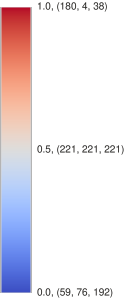

In [8]:
# Build arrays of scalars and colors
scalar_array = pandas.Series(numpy.linspace(0, 1, 1024))
sRGB_array = pandas.Series(diverging_color_map.map_scalar_array(scalar_array))
rgb_array = sRGB_array.apply(lambda color: color.get_value_tuple())

# Create toyplot colormap object
palette = toyplot.color.Palette(colors=rgb_array.values)
colormap = toyplot.color.LinearMap(palette=palette,
                                   domain_min=0, domain_max=1)

# Create toyplot display of colors.
canvas = toyplot.Canvas(width=130, height=300)
numberline = canvas.numberline(x1=16, x2=16, y1=-7, y2=7)
numberline.padding = 30
numberline.axis.spine.show = False
numberline.colormap(colormap,
                    width=30,
                    style={'stroke':'lightgrey'})

control_point_scalars = [0, 0.5, 1]
control_point_labels = []
for scalar in control_point_scalars:
    control_point_labels.append(
        '{:1.1f}, {}'.format(
            scalar,
            diverging_color_map.map_scalar(scalar).get_upscaled_value_tuple()))

numberline.axis.ticks.locator = \
    toyplot.locator.Explicit(locations=control_point_scalars,
                             labels=control_point_labels)
numberline.axis.ticks.labels.angle = -90
numberline.axis.ticks.labels.style = {'text-anchor':'start',
                                      'baseline-shift':'0%',
                                      '-toyplot-anchor-shift':'-15px'}

toyplot.svg.render(canvas, 'smooth-cool-warm.svg')

canvas

## Color Table Files

A convenience function that takes a column of RGB triples in a pandas dataframe, unzips it, and adds three columns to the data frame with the red, green, and blue values.

In [9]:
def unzip_rgb_triple(dataframe, column='RGB'):
    '''Given a dataframe and the name of a column holding an RGB triplet,
    this function creates new separate columns for the R, G, and B values
    with the same name as the original with '_r', '_g', and '_b' appended.'''
    # Creates a data frame with separate columns for the triples in the given column
    unzipped_rgb = pandas.DataFrame(dataframe[column].values.tolist(),
                                    columns=['r', 'g', 'b'])
    # Add the columns to the original data frame
    dataframe[column + '_r'] = unzipped_rgb['r']
    dataframe[column + '_g'] = unzipped_rgb['g']
    dataframe[column + '_b'] = unzipped_rgb['b']

Create several csv files containing color tables for this color map. We will create color tables of many different sizes from 8 rows to 1024. We also write out one set of csv files for "upscaled" color bytes (values 0-255) and another for floating point numbers (0-1).

In [10]:
for num_bits in range(3, 11):
    table_length = 2 ** num_bits
    color_table = pandas.DataFrame()
    color_table['scalar'] = numpy.linspace(0, 1, table_length)
    color_table['sRGBColor'] = \
        diverging_color_map.map_scalar_array(color_table['scalar'])
    color_table['RGB'] = \
        color_table['sRGBColor'].apply(lambda rgb: rgb.get_upscaled_value_tuple())
    color_table['sRGB'] = \
        color_table['sRGBColor'].apply(lambda rgb: rgb.get_value_tuple())
    unzip_rgb_triple(color_table, 'RGB')
    color_table.to_csv('smooth-cool-warm-table-byte-{:04}.csv'.format(table_length),
                       index=False,
                       columns=['scalar', 'RGB_r', 'RGB_g', 'RGB_b'])
    unzip_rgb_triple(color_table, 'sRGB')
    color_table.to_csv('smooth-cool-warm-table-float-{:04}.csv'.format(table_length),
                       index=False,
                       columns=['scalar', 'sRGB_r', 'sRGB_g', 'sRGB_b'],
                       header=['scalar', 'RGB_r', 'RGB_g', 'RGB_b'])